<a href="https://colab.research.google.com/github/shaleenanuj/Machine-Condition-Monitoring/blob/shaleen/PredictiononNASABearingLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CONDITION MONITORING & PREDICTIVE MAINTENANCE 


<font color="blue">This notebook is intended to illustrate conditioning monitoring of industrial machinery by walking  through a real life dataset of bearing vibration data.</font>








# Imports

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

# Data Import

Data can be imported either by reading the file data and taking average of 10 minutes or can be read out of all ready stored file

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
###Data read from raw data files
data_dir = 'data'
merged_data = pd.DataFrame()

# Looping over all files from 12th Feb to 19th Feb
for filename in os.listdir(data_dir):
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
# Renaming columns
merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
# Identifying index as datetime format
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')

FileNotFoundError: ignored

In [3]:
merged_data = pd.read_csv('/content/drive/MyDrive/merged_dataset_BearingTest_2.csv')
merged_data.index = pd.to_datetime(merged_data['Unnamed: 0'])
merged_data.drop('Unnamed: 0',axis=1)
merged_data = merged_data.sort_index()

In [4]:
# Check - Begining of Data
merged_data.head()

,Unnamed: 0,Bearing 1,Bearing 2,Bearing 3,Bearing 4
Unnamed: 0,,,,,
2004-02-12 10:32:39,2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [5]:
# Check - End of Data
merged_data.tail()
#Check Total Points
print(f'Total Data Points {merged_data.shape[0] + 1}')

Total Data Points 985


# Visualising the Data

Text(2004-02-19 06:12:39, 0.3, 'Breakdown of Bearing 1')

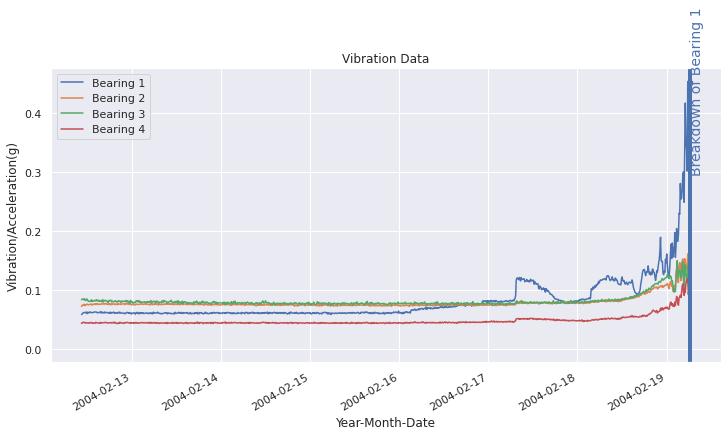

In [6]:
# Visualising Data
ax = merged_data.plot(figsize = (12,6), title="Vibration Data" , legend = True)
ax.set(xlabel="Year-Month-Date", ylabel="Vibration/Acceleration(g)")
plt.axvline(x='2004-02-19 06:12:39', linewidth=4, color='b', label ="Breakdown of Bearing 1")
plt.text('2004-02-19 06:12:39',0.3,'Breakdown of Bearing 1',rotation=90, fontsize=14, color='b')

In [7]:
from fbprophet import Prophet

In [27]:
healthy_bearing1 = merged_data['2004-02-12 10:32:39':'2004-02-15 23:42:39']['Bearing 1']

# Creating training dataframe
LSTM_healthy_train = pd.DataFrame()
#LSTM_healthy_train['ds'] = pd.to_datetime(healthy_bearing1.index)
LSTM_healthy_train['y'] = healthy_bearing1.values

LSTM_healthy_train.head()

,y
0,0.058333
1,0.058995
2,0.060236
3,0.061455
4,0.061361


# Creating Training Data Set and model

In [60]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(LSTM_healthy_train)
#scaled_LSTM_healthy_train = scaler.transform(LSTM_healthy_train)
scaled_LSTM_healthy_train = LSTM_healthy_train)
#scaled_test = scaler.transform(test)
#print(scaled_LSTM_healthy_train)
from keras.preprocessing.sequence import TimeseriesGenerator
# define generator
n_input = 40
n_features = 1
generator = TimeseriesGenerator(scaled_LSTM_healthy_train, scaled_LSTM_healthy_train, length=n_input, batch_size=1)


X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')



Given the Array: 
[0.00812185 0.14279757 0.39518051 0.64304579 0.62379364 0.68562095
 0.74236467 0.59731324 0.81065571 0.32479447 0.82926248 0.51730609
 0.56876762 0.87550141 0.82304698 0.678492   0.73038048 0.60052027
 0.64728544 0.72190119 0.79710274 0.88101195 0.85829461 0.8771794
 0.84497994 0.61731006 0.64235077 0.60710314 0.73472934 0.73136344
 0.69853846 1.         0.48769808 0.808799   0.65755193 0.65385837
 0.47531673 0.89288693 0.5949998  0.63443743]
Predict this y: 
 [[0.66843401]]


[Text(0, 0.5, 'Vibration/Acceleration(g)'),
 Text(0.5, 0, 'Month (MM)-Date(DD) Time')]

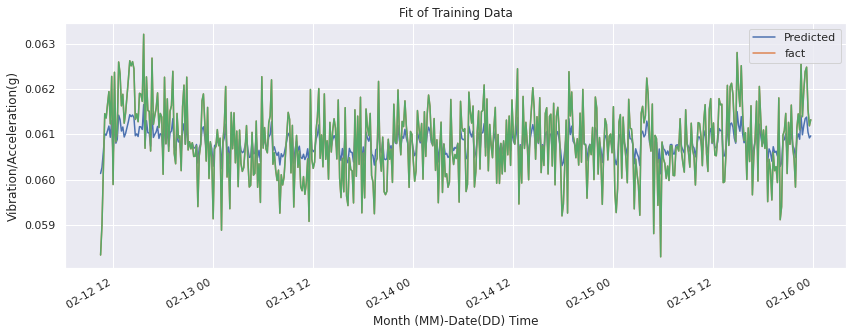

In [98]:

forecast = model.predict(scaled_LSTM_healthy_train)
forecast  = scaler.inverse_transform(forecast)
forecast = pd.DataFrame(forecast)

forecast.rename(columns={0:'Predicted'},inplace=True )
forecast['fact'] = LSTM_healthy_train['y']

forecast.index = healthy_bearing1.index

forecast.head()
#fig1 = model.plot(forecast)
fig1 = forecast.plot(figsize=(14,5))
fig1 = healthy_bearing1.plot(title="Fit of Training Data")
fig1.set(xlabel="Month (MM)-Date(DD) Time", ylabel="Vibration/Acceleration(g)")

Evaluation on test data

In [119]:
faultydata = pd.DataFrame()
faultydata['y'] = merged_data['2004-02-15 23:22:39':'2004-02-16 23:52:39']['Bearing 1']
faultydata.head()

,y
Unnamed: 0,
2004-02-15 23:22:39,0.061558
2004-02-15 23:32:39,0.061188
2004-02-15 23:42:39,0.061323
2004-02-15 23:52:39,0.064163
2004-02-16 00:02:39,0.060751


Displaying Prediction for unseen data plot


[Text(0, 0.5, 'Vibration/Acceleration(g)'),
 Text(0.5, 0, 'Month (MM)-Date(DD) Time')]

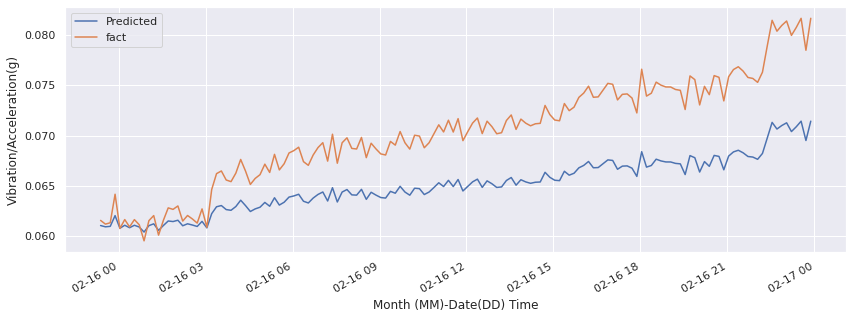

In [123]:
#@title Default title text
faultydata = pd.DataFrame()
faultydata['y'] = merged_data['2004-02-15 23:22:39':'2004-02-16 23:52:39']['Bearing 1']
faultydata.head()

scaled_faultydata = scaler.transform(faultydata)
scaled_faulty_test = pd.DataFrame()


scaled_faulty_test['ds'] = merged_data['2004-02-15 23:22:39':'2004-02-16 23:52:39'].index
#pd.to_datetime(prophet_healthy.index, format='%Y.%m.%d.%H.%M.%S')


scaled_faulty_test['y'] = scaled_faultydata

forecast = model.predict(scaled_faultydata)
forecast  = scaler.inverse_transform(forecast)
forecast = pd.DataFrame(forecast)
forecast.head()
forecast.rename(columns={0:'Predicted'},inplace=True )
forecast.index = faultydata.index
forecast['fact'] = merged_data['2004-02-15 23:22:39':'2004-02-16 23:52:39']['Bearing 1']
forecast.head()
fig1 = forecast.plot(figsize=(14,5))

print('Displaying Prediction for unseen data plot')
#fig1 = m.plot(forecast)
#fig1 = prophet_faultydata.plot(figsize = (12,6),title="Fit of Test/Unseen/Fault Data")
fig1.set(xlabel="Month (MM)-Date(DD) Time", ylabel="Vibration/Acceleration(g)")
#fig1.text(731626.875,0.057,'Expected/Predicted', fontsize=14, color='r')
#fig1.text(731626.875,0.075,'Actual/Faulty Data', fontsize=14, color='r')
#fig1.text(731624.875,0.057,'Actual/Healthy', fontsize=14, color='r')


In [124]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(forecast['fact'],forecast['Predicted']))
print(rmse)

0.005824821555055051


In [ ]:
# Healper functions to annotate the graph.
print(fig1.get_xticks())
print(fig1.get_yticks())

[731624. 731625. 731626. 731627. 731628.]
[0.055 0.06  0.065 0.07  0.075 0.08  0.085]


# References
1.   https://www.plantengineering.com/articles/roller-bearings-and-predictive-analytics/
2.   https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7
3. https://iot.ieee.org/images/files/pdf/phm2017/06-19-2017-Rick-Durham_IEEE-PHM_Presentation20170610.pdf
4. https://facebook.github.io/prophet/docs/quick_start.html
5. https://colab.research.google.com/github/arunptp/Predictive-Analytics/blob/master/BearingAnalytics_.ipynb?authuser=1#scrollTo=U0HbXUA0Sofp